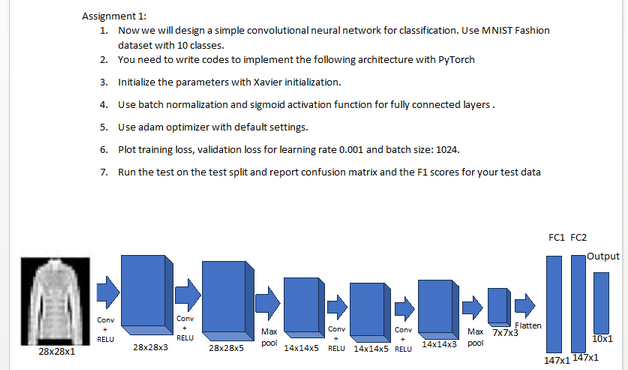

In [ ]:
#Imports and Setup

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns


In [ ]:
#Data Preparation


def get_dataloaders(batch_size=1024):
    """
    Returns train, validation, and test DataLoaders for FashionMNIST.
    """
    # Common transformations:
    # - Convert image to tensor
    # - Normalize with mean=0.5, std=0.5 (typical for MNIST-like data)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Download + create datasets
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    # Split train into train & validation (e.g., 90% train, 10% val)
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
#Model Definition


class FashionCNN(nn.Module):
    """
    CNN for Fashion-MNIST classification with the specified architecture:

    (Conv -> ReLU -> Conv -> ReLU -> MaxPool) ->
    (Conv -> ReLU -> Conv -> ReLU -> MaxPool) ->
    Flatten -> FC1 -> FC2 -> Output
    """
    def __init__(self):
        super(FashionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3, padding=1)

        # Two fully-connected layers; each with batch norm & sigmoid activation
        self.fc1 = nn.Linear(7*7*3, 147)  # 7*7*3 -> 147
        self.bn1 = nn.BatchNorm1d(147)

        self.fc2 = nn.Linear(147, 147)
        self.bn2 = nn.BatchNorm1d(147)

        self.output = nn.Linear(147, 10)

        # Apply Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # First two conv layers + ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # reduce from 28x28 -> 14x14

        # Next two conv layers + ReLU
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)  # reduce from 14x14 -> 7x7

        # Flatten
        x = x.view(x.size(0), -1)  # shape = (batch_size, 7*7*3=147)

        # FC1 -> BN -> Sigmoid
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.sigmoid(x)

        # FC2 -> BN -> Sigmoid
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.sigmoid(x)

        # Output (no softmax needed if using CrossEntropy)
        x = self.output(x)

        return x

In [ ]:
#Training Helper Functions


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_one_epoch(model, dataloader, criterion, device):
    """
    Validate the model for one epoch.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [ ]:
#Main Training Loop and Evaluation

def train_model(num_epochs=10, lr=0.001, batch_size=1024):
    """
    Full training loop: data loading, model init, training, validation, and testing.
    Also plots the loss curves and computes confusion matrix + F1 on test set.
    Additionally, it calculates and displays accuracy on the test set.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, test_loader = get_dataloaders(batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = FashionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # Training + Validation Loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot training & validation loss
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []

    # Counters for accuracy
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Collect predictions and labels for confusion matrix / F1
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate batch accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = correct / total

    # Print confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print F1 scores
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')

    # Print out final metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 macro: {f1_macro:.4f}, F1 micro: {f1_micro:.4f}")

    return model

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.90MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10], Train Loss: 1.1433, Val Loss: 0.7613
Epoch [2/10], Train Loss: 0.6281, Val Loss: 0.5664
Epoch [3/10], Train Loss: 0.5008, Val Loss: 0.4810
Epoch [4/10], Train Loss: 0.4405, Val Loss: 0.4482
Epoch [5/10], Train Loss: 0.4051, Val Loss: 0.4096
Epoch [6/10], Train Loss: 0.3816, Val Loss: 0.4037
Epoch [7/10], Train Loss: 0.3630, Val Loss: 0.3720
Epoch [8/10], Train Loss: 0.3493, Val Loss: 0.3815
Epoch [9/10], Train Loss: 0.3366, Val Loss: 0.3670
Epoch [10/10], Train Loss: 0.3263, Val Loss: 0.3510


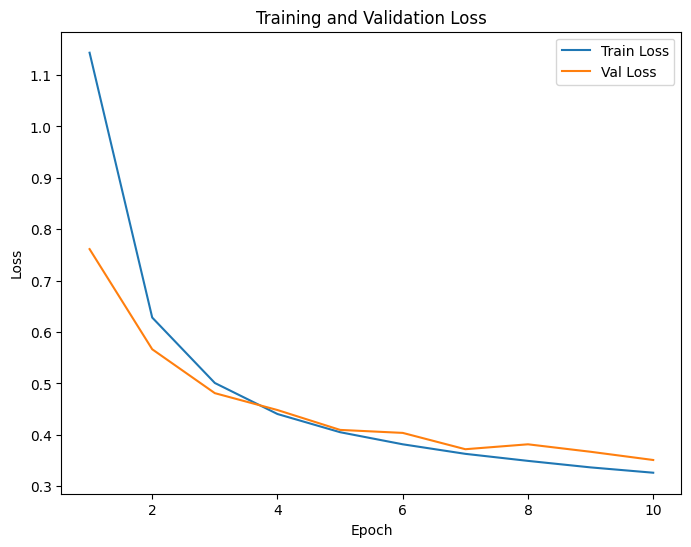

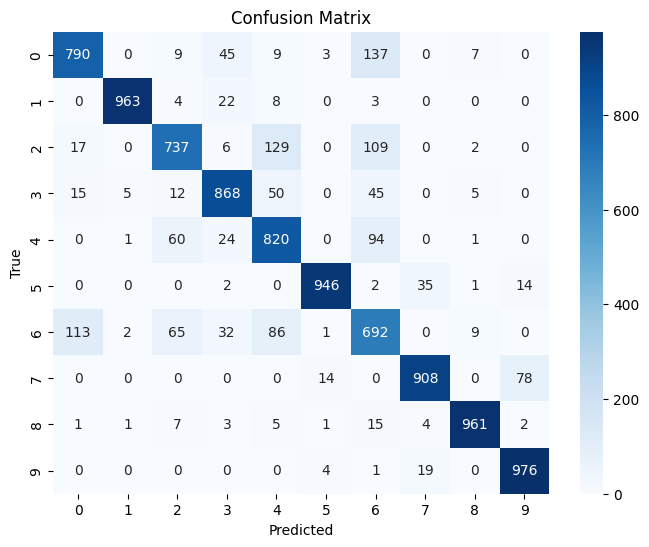

Test Accuracy: 0.8661
F1 macro: 0.8672, F1 micro: 0.8661


In [ ]:
#Run the Training

if __name__ == "__main__":
    trained_model = train_model(num_epochs=10, lr=0.001, batch_size=1024)